In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [83]:
# Load the data
df = pd.read_csv('../../data/processed-v2.csv')


In [84]:
# Check for NaN values in the DataFrame
nan_values = df.isnull().sum()
print("NaN values in each column:")
print(nan_values)

NaN values in each column:
product_id                 0
mrp                        0
ram                        0
inbuilt_storage            0
weight                     0
battery_power              0
battery_type               0
form_factor                0
length                     0
width                      0
height                     0
os_name                    0
os_version                 0
phone_warranty (months)    0
camera_count               0
cam_has_AI                 0
cam_has_OIS                0
cam_has_Zoom               0
cam_has_HDR                0
cam_has_Macro              0
cam_has_Portrait           0
main_camera_MP             0
is_success                 0
dtype: int64


In [85]:
# Let's assume 'is_success' is the target variable
y = df['is_success']
X = df.drop(columns=['is_success', 'product_id'], axis=1)
# X = X.replace([np.inf, -np.inf], np.nan)
# df['os_version'].fillna(df['column'].mean(), inplace=True) 

In [86]:
X = X.replace([np.inf, -np.inf], np.nan)
X["os_version"].fillna(X["os_version"].max() * 2, inplace=True)

In [87]:
X["os_version"].describe()

count    634.000000
mean      13.615615
std        9.573659
min        4.400000
25%       11.000000
50%       12.000000
75%       13.000000
max       60.000000
Name: os_version, dtype: float64

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [89]:
# Models list
models_list = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier()),
    # ("LightGBM", LGBMClassifier(random_state=42)),
    # ("Support Vector Machines", SVC(random_state=42)),
    # ("XGBoost", XGBClassifier(random_state=42)),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("Bernoulli Naive Bayes", BernoulliNB()),
    ("KNN", KNeighborsClassifier(n_neighbors=3)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Bagging Classifier", BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=10))
]

# Initialize DataFrame to store results
result = pd.DataFrame(columns=["Model", "Training Accuracy", "Testing Accuracy", "Classification Report", "Confusion Matrix", "ROC-AUC Score"])

# Loop through models and evaluate performance
for name, model in models_list:
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    train_score = accuracy_score(y_train, train_predictions)
    
    test_predictions = model.predict(X_test)
    test_score = accuracy_score(y_test, test_predictions)

    # Classification Report
    report = classification_report(y_test, test_predictions)

    # Confusion Matrix
    cm = confusion_matrix(y_test, test_predictions)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, test_predictions)

    # Add results to DataFrame
    new_row = {"Model": name, "Training Accuracy": train_score, "Testing Accuracy": test_score, "Classification Report": report, "Confusion Matrix": cm, "ROC-AUC Score": roc_auc}
    result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)

# Sort the results based on Testing Accuracy
result = result.sort_values(by=["Testing Accuracy", "Training Accuracy"], ascending=False)

# Get the best model (model with the highest testing accuracy)
best_model_name = result.iloc[0]['Model']
best_model = [model for name, model in models_list if name == best_model_name][0]


f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [90]:
print(result)


                   Model  Training Accuracy  Testing Accuracy   
1          Random Forest           1.000000          0.960630  \
5          Decision Tree           1.000000          0.944882   
6     Bagging Classifier           0.996055          0.944882   
4                    KNN           0.932939          0.858268   
0    Logistic Regression           0.727811          0.732283   
3  Bernoulli Naive Bayes           0.706114          0.700787   
2   Gaussian Naive Bayes           0.708087          0.661417   

                                                                                                                                                                                                                                                                                                                            Classification Report   
1                precision    recall  f1-score   support\n\n       False       0.97      0.96      0.96        69\n        True       0.95

In [92]:
# Set the maximum column width to None to display all content in cells
pd.set_option('display.max_colwidth', None)

# Print the result DataFrame as a table with variable cell sizes based on content
print(result.to_string(index=False))

                Model  Training Accuracy  Testing Accuracy                                                                                                                                                                                                                                                                                                                          Classification Report     Confusion Matrix  ROC-AUC Score
        Random Forest           1.000000          0.960630               precision    recall  f1-score   support\n\n       False       0.97      0.96      0.96        69\n        True       0.95      0.97      0.96        58\n\n    accuracy                           0.96       127\n   macro avg       0.96      0.96      0.96       127\nweighted avg       0.96      0.96      0.96       127\n   [[66, 3], [2, 56]]       0.961019
        Decision Tree           1.000000          0.944882               precision    recall  f1-score   support\n\n       False       0.97 

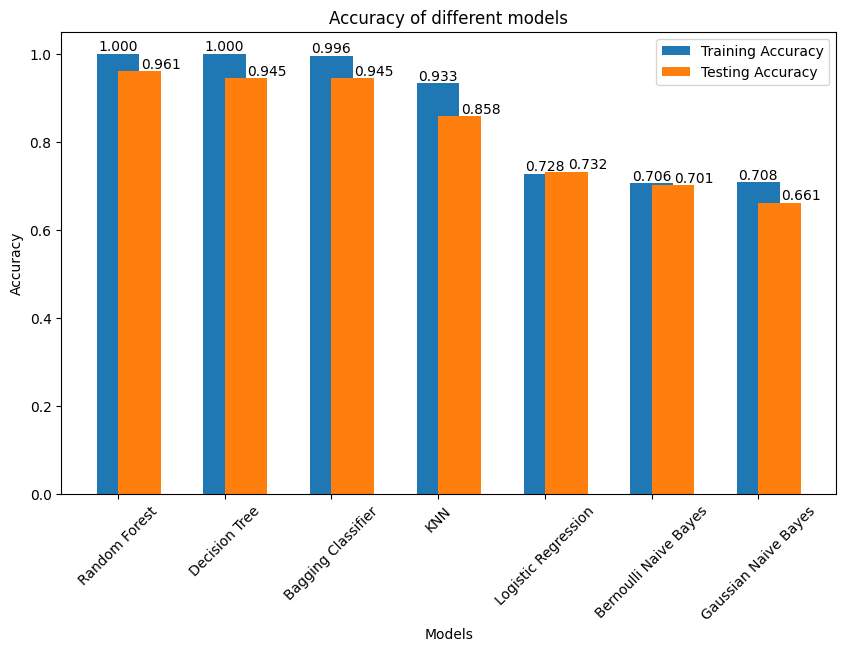

In [93]:
plt.figure(figsize=(10, 6))
bar_width = 0.4
plt.bar(result["Model"], result["Training Accuracy"], width=bar_width, label="Training Accuracy")
plt.bar(result["Model"], result["Testing Accuracy"], width=bar_width, label="Testing Accuracy", align='edge')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of different models')
plt.legend()

# Add labels to the bars
for index, value in enumerate(result["Training Accuracy"]):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

for index, value in enumerate(result["Testing Accuracy"]):
    plt.text(index + bar_width, value, f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()


In [112]:
import streamlit as st
from PIL import Image
from io import BytesIO
from selenium import webdriver

# Display the results as a table
st.table(result)

# Convert DataFrame to HTML
table_html = result.to_html()

# Save the table as a PNG image
driver = webdriver.Chrome()
driver.set_window_size(850, 900)  # Set window size to capture the entire table
driver.get("data:text/html;charset=utf-8," + table_html)

# Capture the table as a screenshot
png_image = driver.get_screenshot_as_png()

# Save the screenshot as a PNG file
image = Image.open(BytesIO(png_image))
image.save("result_table.png")




2023-07-31 04:51:37.508 Applicable driver not found; attempting to install with Selenium Manager (Beta)


In [94]:
# Feature Importance Analysis
if hasattr(best_model, 'feature_importances_'):
    # For tree-based models like RandomForestClassifier
    feature_importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
else:
    # For linear models like LogisticRegression
    feature_importances = best_model.coef_[0]
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': abs(feature_importances)})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the best model and its feature importance
print("Best Performing Model:", best_model_name)
print("Best Testing Accuracy:", result.iloc[0]['Testing Accuracy'])
print("Classification Report:\n", result.iloc[0]['Classification Report'])
print("Confusion Matrix:\n", result.iloc[0]['Confusion Matrix'])
print("ROC-AUC Score:", result.iloc[0]['ROC-AUC Score'])
print("\nFeature Importance:")
print(feature_importance_df)


Best Performing Model: Random Forest
Best Testing Accuracy: 0.9606299212598425
Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.96      0.96        69
        True       0.95      0.97      0.96        58

    accuracy                           0.96       127
   macro avg       0.96      0.96      0.96       127
weighted avg       0.96      0.96      0.96       127

Confusion Matrix:
 [[66  3]
 [ 2 56]]
ROC-AUC Score: 0.9610194902548727

Feature Importance:
                    Feature  Importance
3                    weight    0.171693
10                  os_name    0.125020
0                       mrp    0.113149
7                    length    0.075491
6               form_factor    0.067714
11               os_version    0.064868
8                     width    0.058180
20           main_camera_MP    0.051198
4             battery_power    0.046642
9                    height    0.041719
13             camera_count    0.0391

In [95]:
# Feature Importance Analysis
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [96]:
# Print the best model and its feature importance
print("Best Performing Model:", best_model_name)
print("Best Testing Accuracy:", result.iloc[0]['Testing Accuracy'])
print("Classification Report:\n", result.iloc[0]['Classification Report'])
print("Confusion Matrix:\n", result.iloc[0]['Confusion Matrix'])
print("ROC-AUC Score:", result.iloc[0]['ROC-AUC Score'])
print("\nFeature Importance:")
print(feature_importance_df)

Best Performing Model: Random Forest
Best Testing Accuracy: 0.9606299212598425
Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.96      0.96        69
        True       0.95      0.97      0.96        58

    accuracy                           0.96       127
   macro avg       0.96      0.96      0.96       127
weighted avg       0.96      0.96      0.96       127

Confusion Matrix:
 [[66  3]
 [ 2 56]]
ROC-AUC Score: 0.9610194902548727

Feature Importance:
                    Feature  Importance
3                    weight    0.171693
10                  os_name    0.125020
0                       mrp    0.113149
7                    length    0.075491
6               form_factor    0.067714
11               os_version    0.064868
8                     width    0.058180
20           main_camera_MP    0.051198
4             battery_power    0.046642
9                    height    0.041719
13             camera_count    0.0391

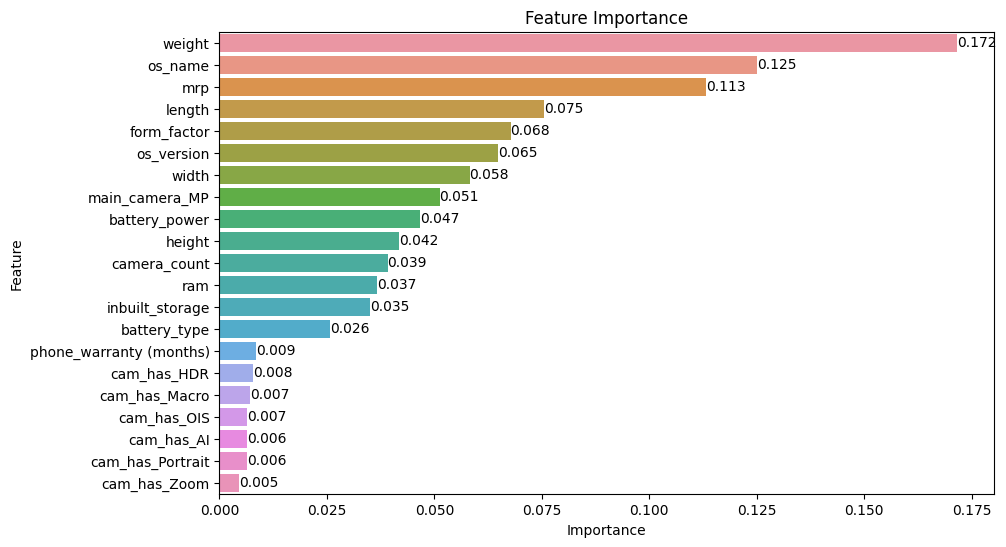

In [97]:
# Feature Importance Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Add annotations to each bar
for index, value in enumerate(feature_importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', ha='left', va='center')

plt.show()

In [18]:
# Hyperparameter Tuning (for Random Forest as an example)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [19]:
# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [20]:
# Best model after hyperparameter tuning
best_model_tuned = grid_search.best_estimator_
best_model_tuned

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=300)

In [101]:
# Cross-Validation
cv_scores_tuned = cross_val_score(best_model_tuned, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Scores:")
print(cv_scores_tuned)

# Calculate mean and standard deviation of cross-validation scores
mean_cv_score = cv_scores_tuned.mean()
std_cv_score = cv_scores_tuned.std()

print(f"\nMean Cross-Validation Score: {mean_cv_score:.4f}")
print(f"Standard Deviation of Cross-Validation Scores: {std_cv_score:.4f}")


Cross-Validation Scores:
[0.92156863 0.94117647 0.98019802 0.91089109 0.95049505]

Mean Cross-Validation Score: 0.9409
Standard Deviation of Cross-Validation Scores: 0.0241


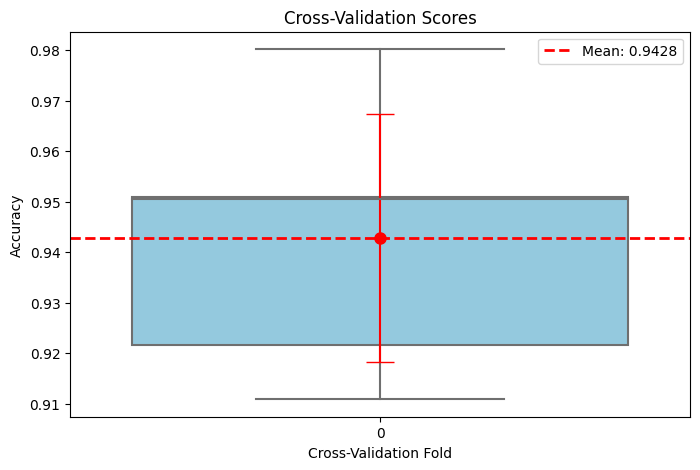

In [117]:
# Cross-Validation
cv_scores_tuned = cross_val_score(best_model_tuned, X_train, y_train, cv=5, scoring='accuracy')

# Calculate mean and standard deviation of cross-validation scores
mean_cv_score = cv_scores_tuned.mean()
std_cv_score = cv_scores_tuned.std()

# Plot the cross-validation scores using a box plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=cv_scores_tuned, color='skyblue')
plt.axhline(mean_cv_score, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_cv_score:.4f}")
plt.errorbar(x=0, y=mean_cv_score, yerr=std_cv_score, color='red', fmt='o', markersize=8, capsize=10)
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.legend()
plt.show()


Training Classification Report (Voting Classifier):
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       261
        True       1.00      1.00      1.00       246

    accuracy                           1.00       507
   macro avg       1.00      1.00      1.00       507
weighted avg       1.00      1.00      1.00       507


Testing Classification Report (Voting Classifier):
              precision    recall  f1-score   support

       False       0.96      0.96      0.96        69
        True       0.95      0.95      0.95        58

    accuracy                           0.95       127
   macro avg       0.95      0.95      0.95       127
weighted avg       0.95      0.95      0.95       127


Confusion Matrix (Voting Classifier):

ROC-AUC Score (Voting Classifier):
0.9523988005997003

Cross-Validation Scores (Voting Classifier):
[0.92156863 0.95098039 0.98019802 0.91089109 0.95049505]


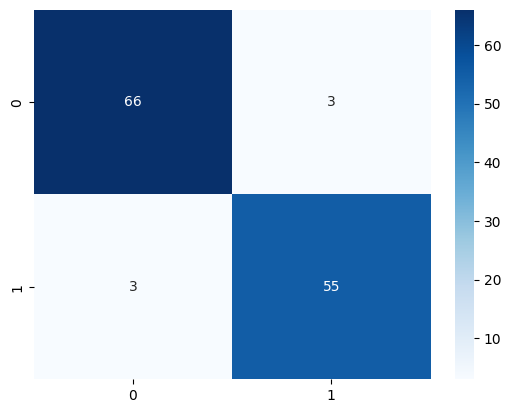

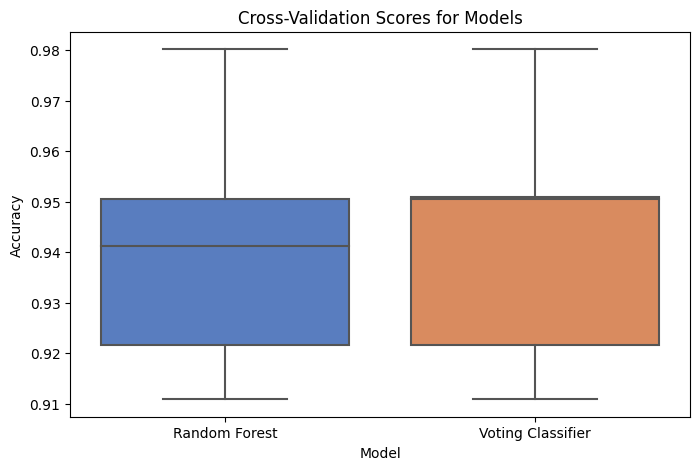

In [24]:
from sklearn.ensemble import VotingClassifier

# Create Voting Classifier
voting_classifier = VotingClassifier(estimators=[('best_model', best_model), ('best_model_tuned', best_model_tuned)], voting='hard')

# Train and evaluate Voting Classifier
voting_classifier.fit(X_train, y_train)

train_predictions_voting = voting_classifier.predict(X_train)
test_predictions_voting = voting_classifier.predict(X_test)

print("\nTraining Classification Report (Voting Classifier):")
print(classification_report(y_train, train_predictions_voting))

print("\nTesting Classification Report (Voting Classifier):")
print(classification_report(y_test, test_predictions_voting))

print("\nConfusion Matrix (Voting Classifier):")
cm_voting = confusion_matrix(y_test, test_predictions_voting)
sns.heatmap(cm_voting, annot=True, cmap='Blues', fmt='d')

print("\nROC-AUC Score (Voting Classifier):")
roc_auc_voting = roc_auc_score(y_test, test_predictions_voting)
print(roc_auc_voting)

# Cross-Validation (Voting Classifier)
cv_scores_voting = cross_val_score(voting_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Scores (Voting Classifier):")
print(cv_scores_voting)

# Plot Cross-Validation Scores for all models
cv_scores_all = {
    'Random Forest': cv_scores_tuned,
    'Voting Classifier': cv_scores_voting
}

plt.figure(figsize=(8, 5))
sns.boxplot(data=pd.DataFrame(cv_scores_all), palette='muted')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Models')
plt.show()



Training Classification Report (Stacking Classifier):
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       261
        True       1.00      1.00      1.00       246

    accuracy                           1.00       507
   macro avg       1.00      1.00      1.00       507
weighted avg       1.00      1.00      1.00       507


Testing Classification Report (Stacking Classifier):
              precision    recall  f1-score   support

       False       0.96      0.96      0.96        69
        True       0.95      0.95      0.95        58

    accuracy                           0.95       127
   macro avg       0.95      0.95      0.95       127
weighted avg       0.95      0.95      0.95       127


Confusion Matrix (Stacking Classifier):

ROC-AUC Score (Stacking Classifier):
0.9523988005997003

Cross-Validation Scores (Stacking Classifier):
[0.92156863 0.96078431 0.98019802 0.91089109 0.94059406]


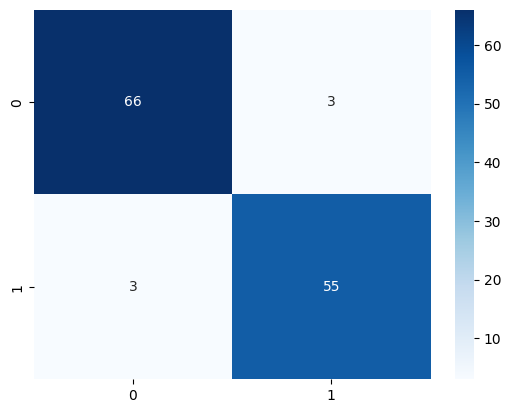

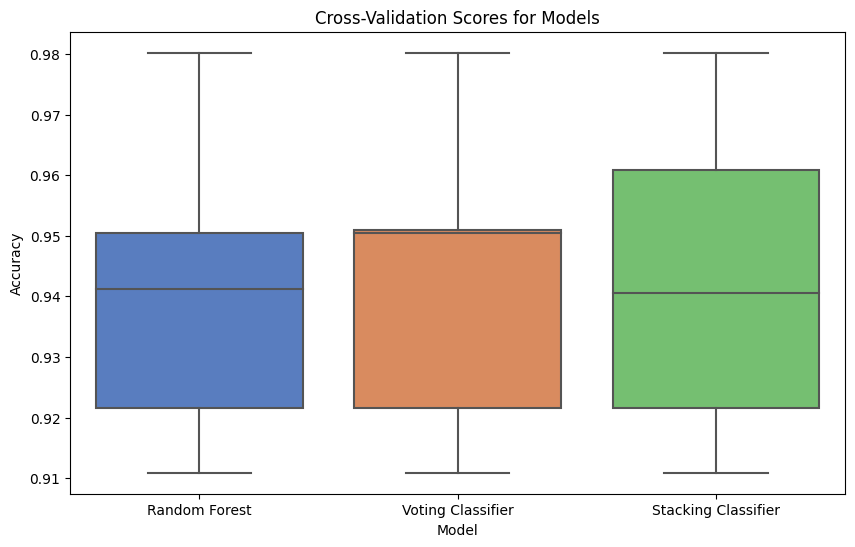

In [25]:
from sklearn.ensemble import StackingClassifier

# Create Stacking Classifier
stacking_classifier = StackingClassifier(estimators=[('best_model', best_model), ('best_model_tuned', best_model_tuned)],
                                         final_estimator=LogisticRegression())

# Train and evaluate Stacking Classifier
stacking_classifier.fit(X_train, y_train)

train_predictions_stacking = stacking_classifier.predict(X_train)
test_predictions_stacking = stacking_classifier.predict(X_test)

print("\nTraining Classification Report (Stacking Classifier):")
print(classification_report(y_train, train_predictions_stacking))

print("\nTesting Classification Report (Stacking Classifier):")
print(classification_report(y_test, test_predictions_stacking))

print("\nConfusion Matrix (Stacking Classifier):")
cm_stacking = confusion_matrix(y_test, test_predictions_stacking)
sns.heatmap(cm_stacking, annot=True, cmap='Blues', fmt='d')

print("\nROC-AUC Score (Stacking Classifier):")
roc_auc_stacking = roc_auc_score(y_test, test_predictions_stacking)
print(roc_auc_stacking)

# Cross-Validation (Stacking Classifier)
cv_scores_stacking = cross_val_score(stacking_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Scores (Stacking Classifier):")
print(cv_scores_stacking)

# Plot Cross-Validation Scores for all models
cv_scores_all['Stacking Classifier'] = cv_scores_stacking

plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(cv_scores_all), palette='muted')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Models')
plt.show()


f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Training Classification Report (AdaBoost Classifier):
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       261
        True       1.00      1.00      1.00       246

    accuracy                           1.00       507
   macro avg       1.00      1.00      1.00       507
weighted avg       1.00      1.00      1.00       507


Testing Classification Report (AdaBoost Classifier):
              precision    recall  f1-score   support

       False       0.96      0.94      0.95        69
        True       0.93      0.95      0.94        58

    accuracy                           0.94       127
   macro avg       0.94      0.95      0.94       127
weighted avg       0.95      0.94      0.94       127


Confusion Matrix (AdaBoost Classifier):

ROC-AUC Score (AdaBoost Classifier):
0.9451524237881059


f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Cross-Validation Scores (AdaBoost Classifier):
[0.92156863 0.95098039 0.98019802 0.91089109 0.95049505]


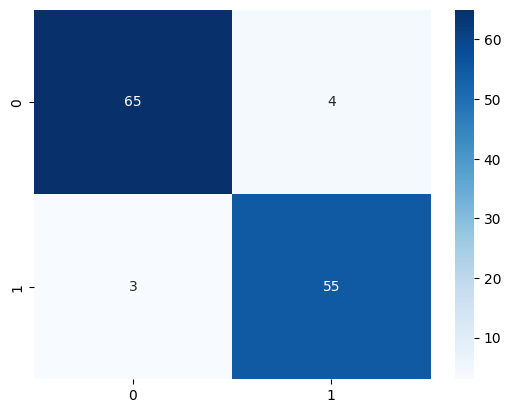

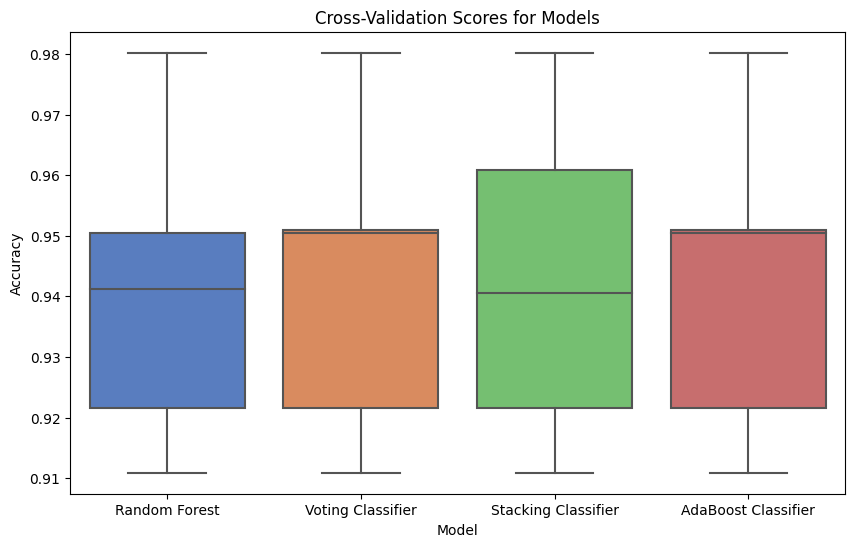

In [26]:
from sklearn.ensemble import AdaBoostClassifier

# Create AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier(base_estimator=best_model_tuned, n_estimators=50, random_state=42)

# Train and evaluate AdaBoost Classifier
adaboost_classifier.fit(X_train, y_train)

train_predictions_boosting = adaboost_classifier.predict(X_train)
test_predictions_boosting = adaboost_classifier.predict(X_test)

print("\nTraining Classification Report (AdaBoost Classifier):")
print(classification_report(y_train, train_predictions_boosting))

print("\nTesting Classification Report (AdaBoost Classifier):")
print(classification_report(y_test, test_predictions_boosting))

print("\nConfusion Matrix (AdaBoost Classifier):")
cm_boosting = confusion_matrix(y_test, test_predictions_boosting)
sns.heatmap(cm_boosting, annot=True, cmap='Blues', fmt='d')

print("\nROC-AUC Score (AdaBoost Classifier):")
roc_auc_boosting = roc_auc_score(y_test, test_predictions_boosting)
print(roc_auc_boosting)

# Cross-Validation (AdaBoost Classifier)
cv_scores_boosting = cross_val_score(adaboost_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Scores (AdaBoost Classifier):")
print(cv_scores_boosting)

# Plot Cross-Validation Scores for all models
cv_scores_all['AdaBoost Classifier'] = cv_scores_boosting

plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(cv_scores_all), palette='muted')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Models')
plt.show()


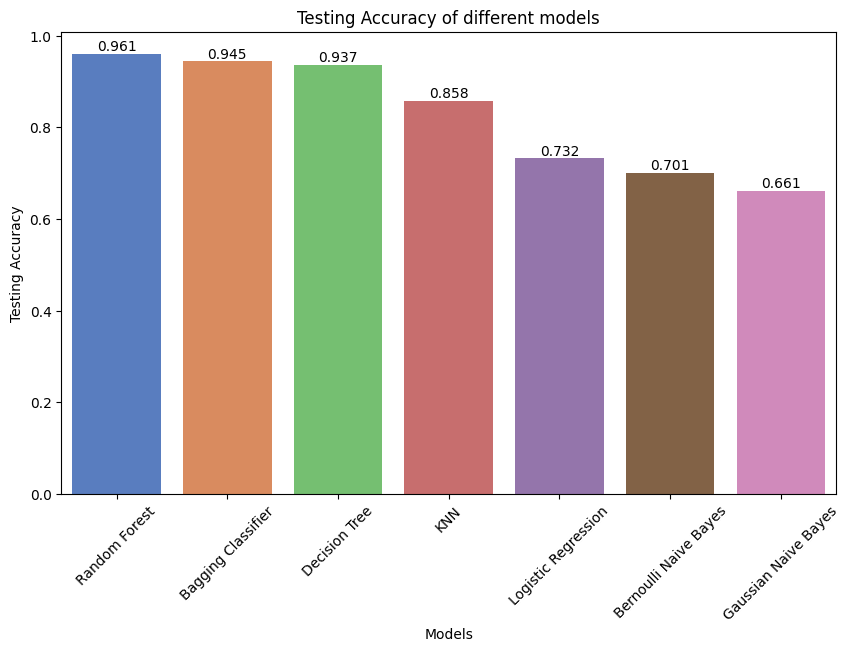

In [27]:
# Voting Classifier
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Testing Accuracy', data=result, palette='muted')
plt.xlabel('Models')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy of different models')
for index, value in enumerate(result["Testing Accuracy"]):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

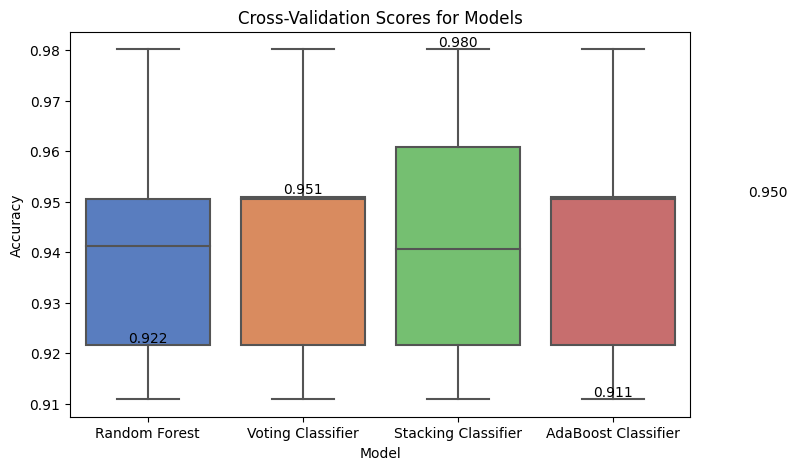

In [28]:
# Voting Classifier Performance Visualization
plt.figure(figsize=(8, 5))
sns.boxplot(data=pd.DataFrame(cv_scores_all), palette='muted')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Models')
for i, v in enumerate(cv_scores_voting):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
plt.show()

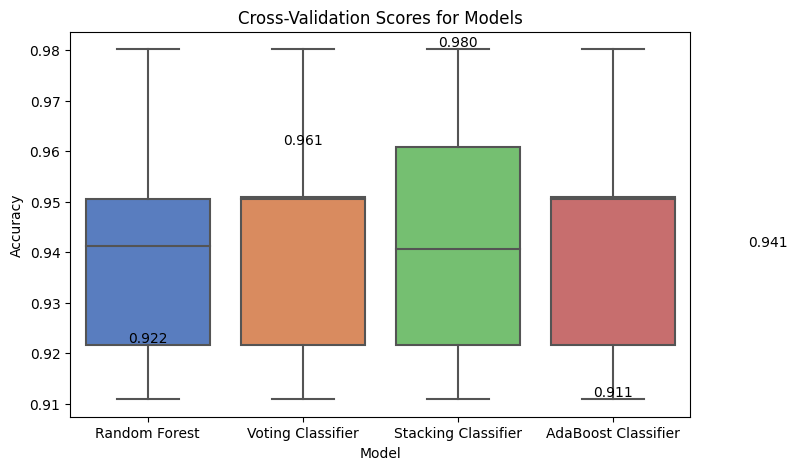

In [29]:
# Stacking Classifier Performance Visualization
plt.figure(figsize=(8, 5))
sns.boxplot(data=pd.DataFrame(cv_scores_all), palette='muted')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Models')
for i, v in enumerate(cv_scores_stacking):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
plt.show()

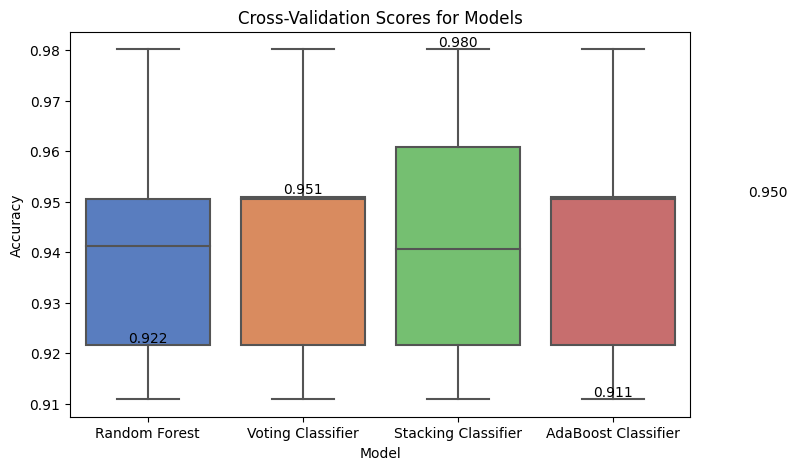

In [30]:
# AdaBoost Classifier Performance Visualization
plt.figure(figsize=(8, 5))
sns.boxplot(data=pd.DataFrame(cv_scores_all), palette='muted')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Models')
for i, v in enumerate(cv_scores_boosting):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
plt.show()

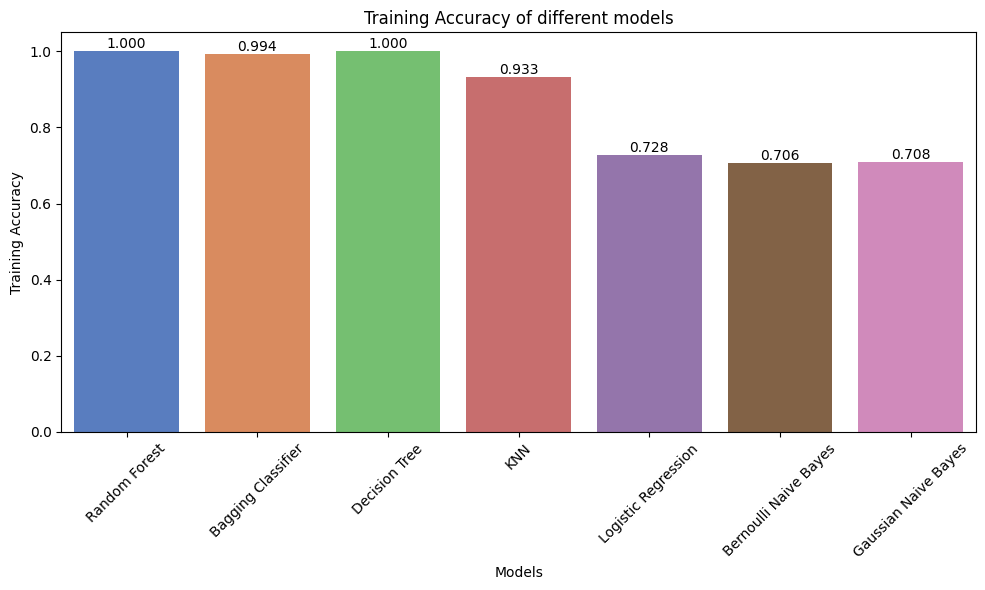

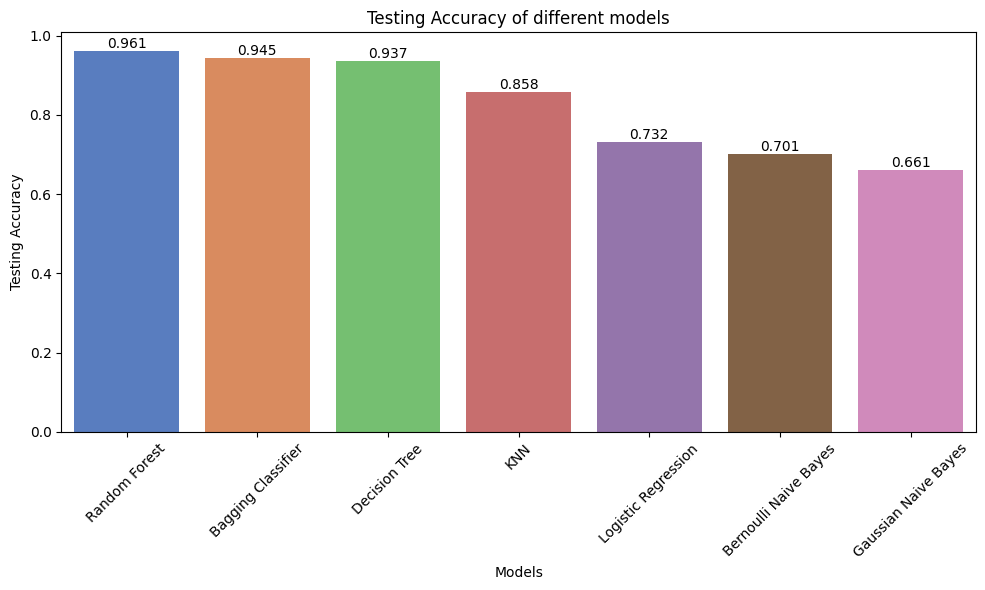

In [31]:
# Chart 1: Training Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Training Accuracy', data=result, palette='muted')
plt.xlabel('Models')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy of different models')

# Add labels to the bars
for index, value in enumerate(result["Training Accuracy"]):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Chart 2: Testing Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Testing Accuracy', data=result, palette='muted')
plt.xlabel('Models')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy of different models')

# Add labels to the bars
for index, value in enumerate(result["Testing Accuracy"]):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


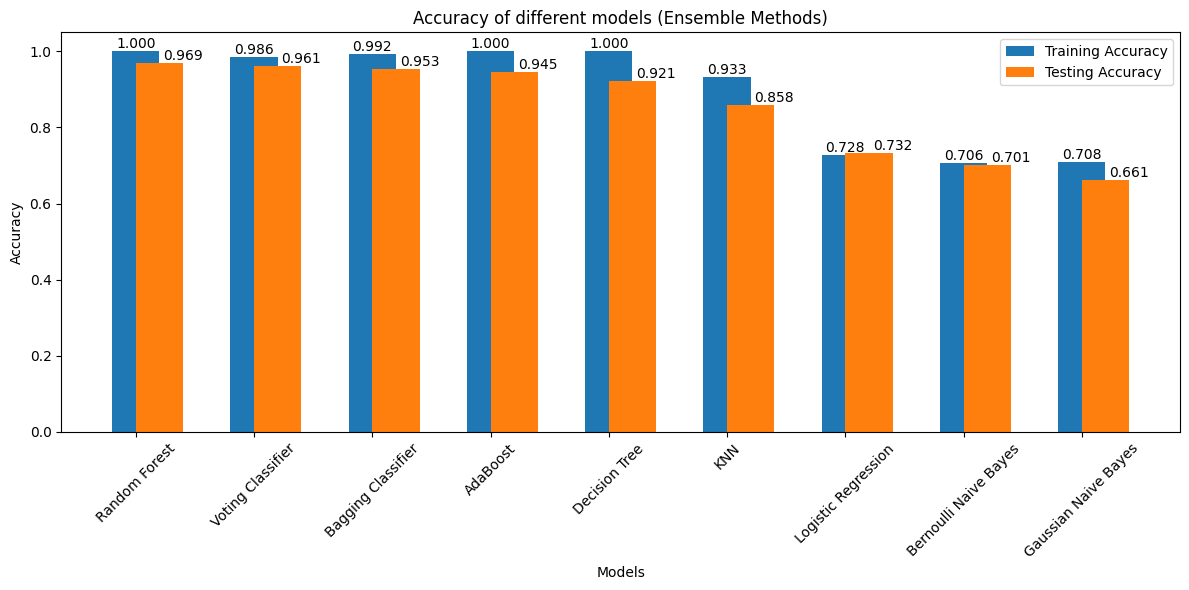

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

# Load the data
df = pd.read_csv('../../data/processed-v2.csv')

# Let's assume 'is_success' is the target variable
y = df['is_success']
X = df.drop(columns=['is_success', 'product_id'], axis=1)

# X = X.replace([np.inf, -np.inf], np.nan)
# df['os_version'].fillna(df['column'].mean(), inplace=True) 
X = X.replace([np.inf, -np.inf], np.nan)
X["os_version"].fillna(X["os_version"].max() * 2, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models list
models_list = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier()),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("Bernoulli Naive Bayes", BernoulliNB()),
    ("KNN", KNeighborsClassifier(n_neighbors=3)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Bagging Classifier", BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=10)),
    ("Voting Classifier", VotingClassifier(estimators=[("lr", LogisticRegression(max_iter=1000)),
                                                        ("rf", RandomForestClassifier()),
                                                        ("bnb", BernoulliNB()),
                                                        ("knn", KNeighborsClassifier(n_neighbors=3)),
                                                        ("dt", DecisionTreeClassifier())])),
    ("AdaBoost", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50))
]

# Initialize DataFrame to store results
result = pd.DataFrame(columns=["Model", "Training Accuracy", "Testing Accuracy", "Classification Report", "Confusion Matrix", "ROC-AUC Score"])

# Loop through models and evaluate performance
for name, model in models_list:
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    train_score = accuracy_score(y_train, train_predictions)
    
    test_predictions = model.predict(X_test)
    test_score = accuracy_score(y_test, test_predictions)

    # Classification Report
    report = classification_report(y_test, test_predictions)

    # Confusion Matrix
    cm = confusion_matrix(y_test, test_predictions)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, test_predictions)

    # Add results to DataFrame
    new_row = {"Model": name, "Training Accuracy": train_score, "Testing Accuracy": test_score, "Classification Report": report, "Confusion Matrix": cm, "ROC-AUC Score": roc_auc}
    result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)

# Sort the results based on Testing Accuracy
result = result.sort_values(by=["Testing Accuracy", "Training Accuracy"], ascending=False)

# Visualization for Ensemble Methods
plt.figure(figsize=(12, 6))
bar_width = 0.4
plt.bar(result["Model"], result["Training Accuracy"], width=bar_width, label="Training Accuracy", align='center')
plt.bar(result["Model"], result["Testing Accuracy"], width=bar_width, label="Testing Accuracy", align='edge')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of different models (Ensemble Methods)')
plt.legend()

# Add labels to the bars for both training and testing accuracies
for index, value in enumerate(result["Training Accuracy"]):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

for index, value in enumerate(result["Testing Accuracy"]):
    plt.text(index + bar_width, value, f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
f:\an-001-masters1newtrail\venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


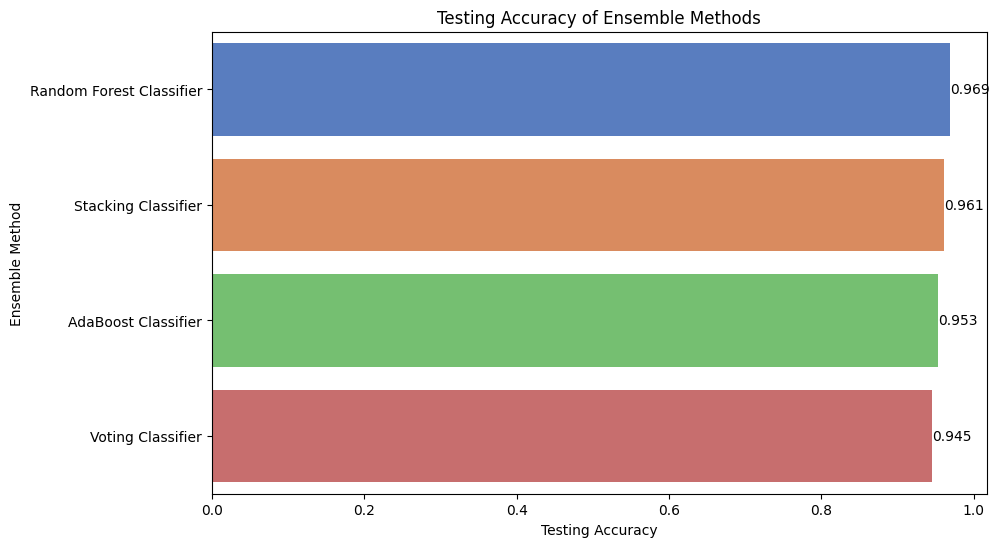

                      Model  Training Accuracy  Testing Accuracy   
3  Random Forest Classifier           1.000000          0.968504  \
1       Stacking Classifier           0.998028          0.960630   
2       AdaBoost Classifier           1.000000          0.952756   
0         Voting Classifier           0.988166          0.944882   

                               Classification Report    Confusion Matrix   
3                precision    recall  f1-score   ...  [[66, 3], [1, 57]]  \
1                precision    recall  f1-score   ...  [[66, 3], [2, 56]]   
2                precision    recall  f1-score   ...  [[63, 6], [0, 58]]   
0                precision    recall  f1-score   ...  [[65, 4], [3, 55]]   

   ROC-AUC Score  
3       0.969640  
1       0.961019  
2       0.956522  
0       0.945152  


In [33]:
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt

# Create ensemble models
voting_classifier = VotingClassifier(models_list)
stacking_classifier = StackingClassifier(estimators=models_list, final_estimator=LogisticRegression())
adaboost_classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
random_forest_classifier = RandomForestClassifier()

# Train and evaluate ensemble models
ensemble_models = [
    ("Voting Classifier", voting_classifier),
    ("Stacking Classifier", stacking_classifier),
    ("AdaBoost Classifier", adaboost_classifier),
    ("Random Forest Classifier", random_forest_classifier)
]

result_ensemble = pd.DataFrame(columns=["Model", "Training Accuracy", "Testing Accuracy", "Classification Report", "Confusion Matrix", "ROC-AUC Score"])

for name, model in ensemble_models:
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    train_score = accuracy_score(y_train, train_predictions)

    test_predictions = model.predict(X_test)
    test_score = accuracy_score(y_test, test_predictions)

    # Classification Report
    report = classification_report(y_test, test_predictions)

    # Confusion Matrix
    cm = confusion_matrix(y_test, test_predictions)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, test_predictions)

    # Add results to DataFrame
    new_row = {"Model": name, "Training Accuracy": train_score, "Testing Accuracy": test_score, "Classification Report": report, "Confusion Matrix": cm, "ROC-AUC Score": roc_auc}
    result_ensemble = pd.concat([result_ensemble, pd.DataFrame([new_row])], ignore_index=True)

# Sort the results based on Testing Accuracy
result_ensemble = result_ensemble.sort_values(by=["Testing Accuracy", "Training Accuracy"], ascending=False)

# Visualize Testing Accuracy of Ensemble Methods
plt.figure(figsize=(10, 6))
sns.barplot(x='Testing Accuracy', y='Model', data=result_ensemble, palette='muted')
plt.xlabel('Testing Accuracy')
plt.ylabel('Ensemble Method')
plt.title('Testing Accuracy of Ensemble Methods')
for index, value in enumerate(result_ensemble["Testing Accuracy"]):
    plt.text(value, index, f'{value:.3f}', ha='left', va='center')

plt.xticks(rotation=0)
plt.show()

# Print the results of each ensemble method
print(result_ensemble)

# Visualize the feature importance of the best-performing ensemble (Random Forest)
best_ensemble_name = result_ensemble.iloc[0]['Model']
best_ensemble = [model for name, model in ensemble_models if name == best_ensemble_name][0]

# ... (rest of your feature importance visualization code as before)


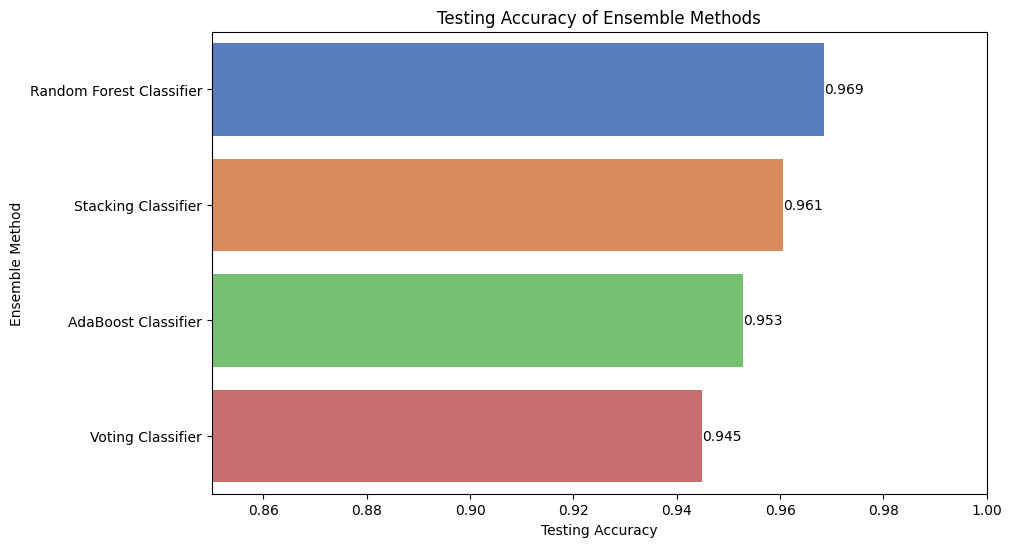


Cross-Validation Scores for Ensemble Methods:
   Random Forest  Voting Classifier  Stacking Classifier  AdaBoost Classifier
0       0.921569           0.921569             0.921569             0.921569
1       0.950980           0.950980             0.960784             0.950980
2       0.990099           0.980198             0.980198             0.980198
3       0.910891           0.910891             0.910891             0.910891
4       0.950495           0.950495             0.940594             0.950495

Best Performing Model: Random Forest
Best Testing Accuracy: 0.968503937007874
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.96      0.97        69
        True       0.95      0.98      0.97        58

    accuracy                           0.97       127
   macro avg       0.97      0.97      0.97       127
weighted avg       0.97      0.97      0.97       127

Confusion Matrix:
 [[66  3]
 [ 1 57]]
ROC-AUC Score: 0.

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Cross-Validation for Random Forest
cv_scores_rf = cross_val_score(best_model_tuned, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_all['Random Forest'] = cv_scores_rf

# Create a DataFrame for cross-validation scores
cv_scores_df = pd.DataFrame(cv_scores_all)

# Visualize Testing Accuracy of Ensemble Methods
plt.figure(figsize=(10, 6))
sns.barplot(x='Testing Accuracy', y='Model', data=result_ensemble, palette='muted', orient='h')
plt.xlabel('Testing Accuracy')
plt.ylabel('Ensemble Method')
plt.title('Testing Accuracy of Ensemble Methods')

# Add labels to the bars
for index, value in enumerate(result_ensemble["Testing Accuracy"]):
    plt.text(value, index, f'{value:.3f}', ha='left', va='center')

plt.xlim(0.85, 1.0)  # Set the x-axis limit to better visualize differences in accuracy

plt.show()


# Print the table structure
print("\nCross-Validation Scores for Ensemble Methods:")
print(cv_scores_df)

# Print the best model and its feature importance
print("\nBest Performing Model:", best_model_name)
print("Best Testing Accuracy:", result.iloc[0]['Testing Accuracy'])
print("Classification Report:\n", result.iloc[0]['Classification Report'])
print("Confusion Matrix:\n", result.iloc[0]['Confusion Matrix'])
print("ROC-AUC Score:", result.iloc[0]['ROC-AUC Score'])
print("\nFeature Importance:")
print(feature_importance_df)




In [98]:
print(feature_importance_df)

                    Feature  Importance
3                    weight    0.171693
10                  os_name    0.125020
0                       mrp    0.113149
7                    length    0.075491
6               form_factor    0.067714
11               os_version    0.064868
8                     width    0.058180
20           main_camera_MP    0.051198
4             battery_power    0.046642
9                    height    0.041719
13             camera_count    0.039120
1                       ram    0.036606
2           inbuilt_storage    0.035102
5              battery_type    0.025832
12  phone_warranty (months)    0.008570
17              cam_has_HDR    0.007850
18            cam_has_Macro    0.007231
15              cam_has_OIS    0.006529
14               cam_has_AI    0.006416
19         cam_has_Portrait    0.006408
16             cam_has_Zoom    0.004660



Best Model (Before Hyperparameter Tuning):
RandomForestClassifier()

Best Hyperparameters (After Hyperparameter Tuning):
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Evaluation of the Best Model (Before Hyperparameter Tuning):
Training Classification Report (Before Tuning):
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       261
        True       1.00      1.00      1.00       246

    accuracy                           1.00       507
   macro avg       1.00      1.00      1.00       507
weighted avg       1.00      1.00      1.00       507


Testing Classification Report (Before Tuning):
              precision    recall  f1-score   support

       False       0.97      0.96      0.96        69
        True       0.95      0.97      0.96        58

    accuracy                           0.96       127
   macro avg       0.96      0.96      0.96       127
weighted avg   

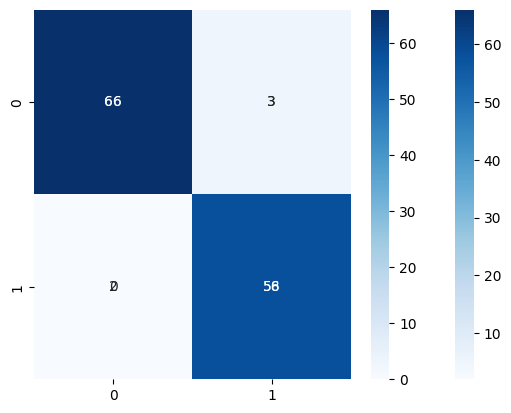

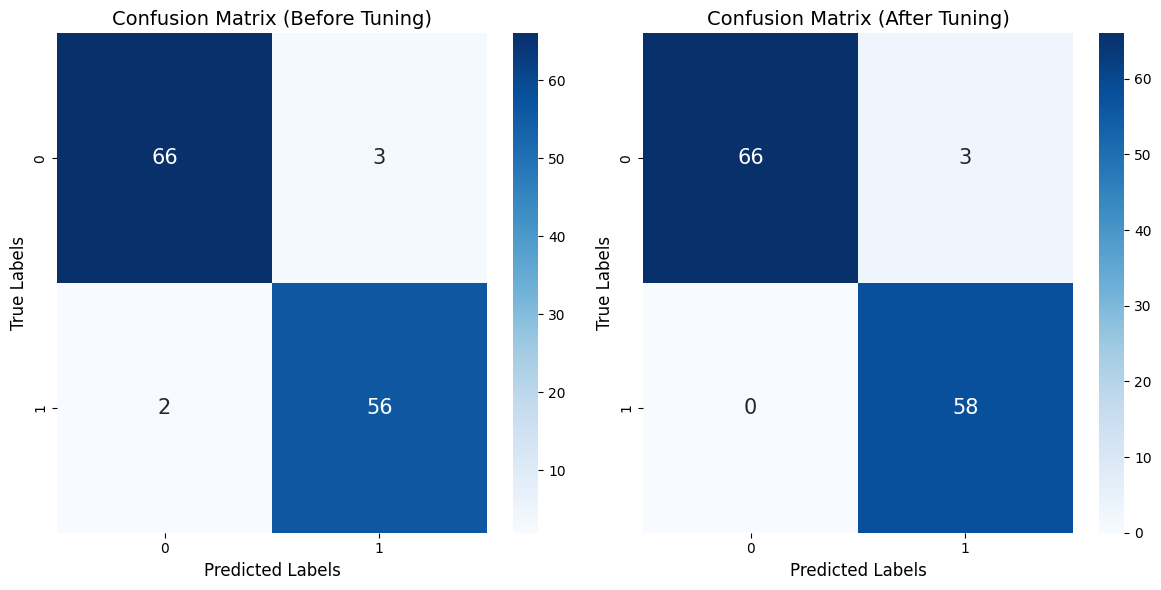

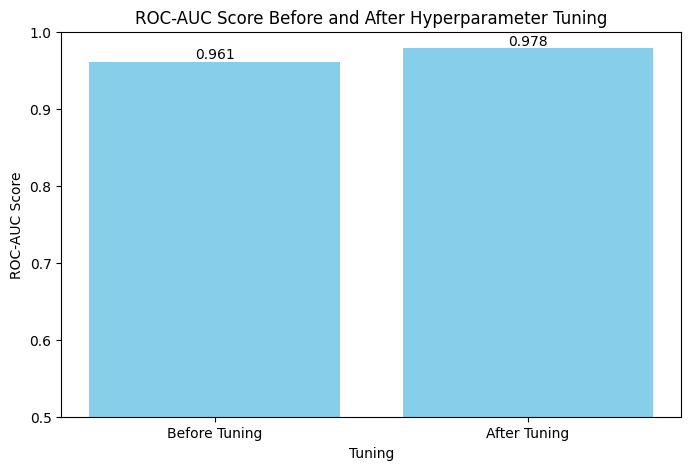

In [99]:

# Print the best model before tuning
print("\nBest Model (Before Hyperparameter Tuning):")
print(best_model)

# Hyperparameter Tuning (for Random Forest as an example)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("\nBest Hyperparameters (After Hyperparameter Tuning):")
print(best_params)

# Best model after hyperparameter tuning
best_model_tuned = grid_search.best_estimator_

# Evaluate the best model before tuning
print("\nEvaluation of the Best Model (Before Hyperparameter Tuning):")
train_predictions_before_tuning = best_model.predict(X_train)
test_predictions_before_tuning = best_model.predict(X_test)

print("Training Classification Report (Before Tuning):")
print(classification_report(y_train, train_predictions_before_tuning))

print("\nTesting Classification Report (Before Tuning):")
print(classification_report(y_test, test_predictions_before_tuning))

print("\nConfusion Matrix (Before Tuning):")
cm_before_tuning = confusion_matrix(y_test, test_predictions_before_tuning)
sns.heatmap(cm_before_tuning, annot=True, cmap='Blues', fmt='d')

print("\nROC-AUC Score (Before Tuning):")
roc_auc_before_tuning = roc_auc_score(y_test, test_predictions_before_tuning)
print(roc_auc_before_tuning)

# Evaluate the best model after tuning
print("\nEvaluation of the Best Model (After Hyperparameter Tuning):")
train_predictions_after_tuning = best_model_tuned.predict(X_train)
test_predictions_after_tuning = best_model_tuned.predict(X_test)

print("Training Classification Report (After Tuning):")
print(classification_report(y_train, train_predictions_after_tuning))

print("\nTesting Classification Report (After Tuning):")
print(classification_report(y_test, test_predictions_after_tuning))

print("\nConfusion Matrix (After Tuning):")
cm_after_tuning = confusion_matrix(y_test, test_predictions_after_tuning)
sns.heatmap(cm_after_tuning, annot=True, cmap='Blues', fmt='d')

print("\nROC-AUC Score (After Tuning):")
roc_auc_after_tuning = roc_auc_score(y_test, test_predictions_after_tuning)
print(roc_auc_after_tuning)

# Visualize the difference in model performance before and after tuning
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_before_tuning, annot=True, cmap='Blues', fmt='d', annot_kws={"size": 15})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix (Before Tuning)', fontsize=14)

plt.subplot(1, 2, 2)
sns.heatmap(cm_after_tuning, annot=True, cmap='Blues', fmt='d', annot_kws={"size": 15})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix (After Tuning)', fontsize=14)

plt.tight_layout()
plt.show()

# Visualize the difference in ROC-AUC score before and after tuning
plt.figure(figsize=(8, 5))
plt.bar(["Before Tuning", "After Tuning"], [roc_auc_before_tuning, roc_auc_after_tuning], color='skyblue')
plt.xlabel('Tuning')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Score Before and After Hyperparameter Tuning')
plt.ylim(0.5, 1.0)

# Add labels to the bars
for index, value in enumerate([roc_auc_before_tuning, roc_auc_after_tuning]):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')

plt.show()




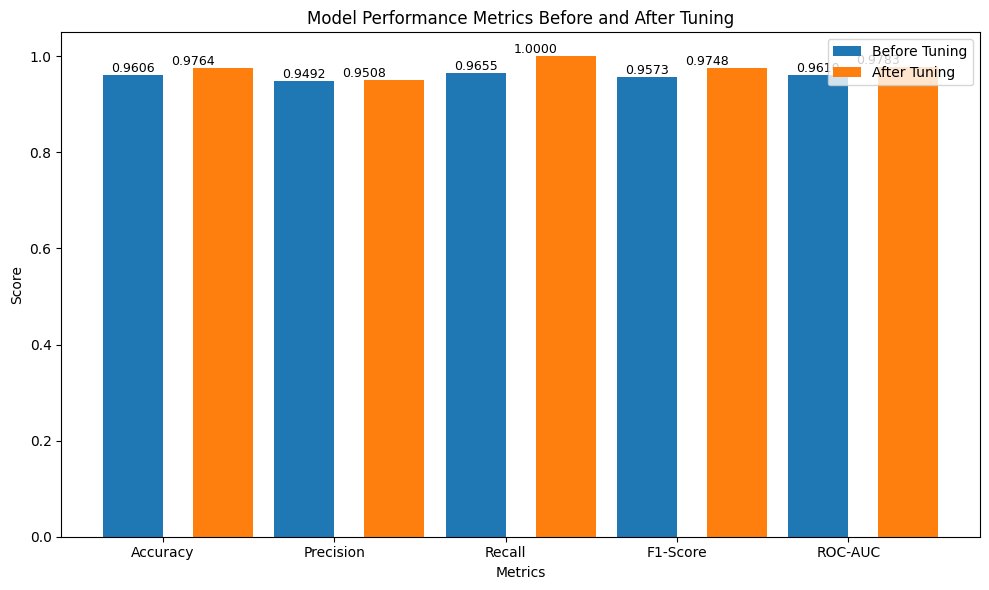

In [105]:
import matplotlib.pyplot as plt

# Define the performance metrics before and after tuning
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
before_tuning = [0.9606, 0.9492, 0.9655, 0.9573, 0.9610]
after_tuning = [0.9764, 0.9508, 1.0000, 0.9748, 0.9783]

# Plot the bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = list(range(len(metrics)))
plt.bar(index, before_tuning, bar_width, label='Before Tuning')
plt.bar([i + bar_width for i in index], after_tuning, bar_width, label='After Tuning', align='edge')

# Add labels to the bars
for i, v in enumerate(before_tuning):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9, color='black')

for i, v in enumerate(after_tuning):
    plt.text(i + bar_width, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9, color='black')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Metrics Before and After Tuning')
plt.xticks([i + bar_width/2 for i in index], metrics)
plt.legend()
plt.tight_layout()
plt.show()


In [106]:
# Feature Importance Analysis
feature_importances = best_model_tuned.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [ ]:
# Print the best model and its feature importance
print("Best Performing Model:", best_model_name)
print("Best Testing Accuracy:", result.iloc[0]['Testing Accuracy'])
print("Classification Report:\n", result.iloc[0]['Classification Report'])
print("Confusion Matrix:\n", result.iloc[0]['Confusion Matrix'])
print("ROC-AUC Score:", result.iloc[0]['ROC-AUC Score'])
print("\nFeature Importance:")
print(feature_importance_df)

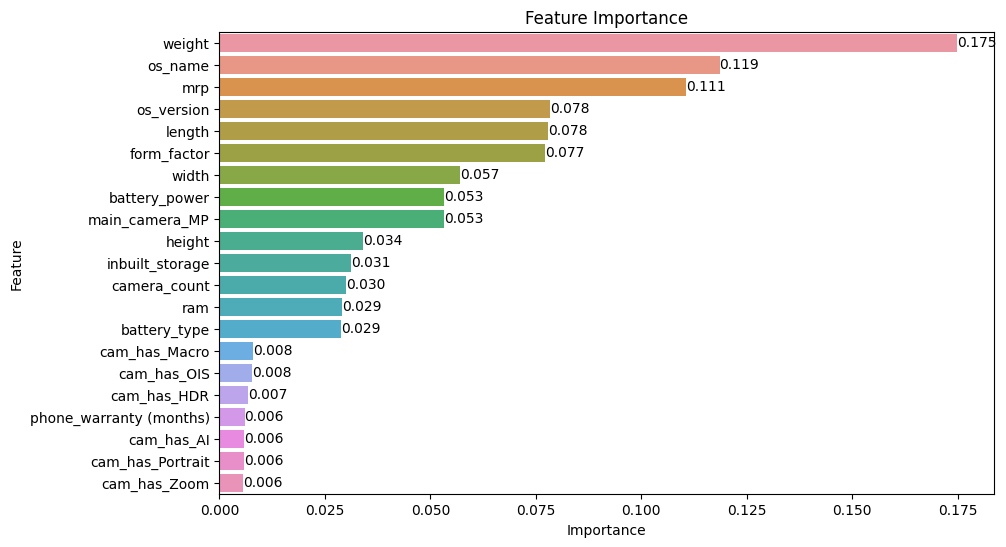

In [107]:
# Feature Importance Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Add annotations to each bar
for index, value in enumerate(feature_importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', ha='left', va='center')

plt.show()

In [119]:


# Import the required function for evaluation metrics
from sklearn.metrics import precision_recall_fscore_support

# Calculate evaluation metrics for the best model before tuning
precision_before_tuning, recall_before_tuning, f1_before_tuning, _ = precision_recall_fscore_support(y_test, test_predictions_before_tuning, average='binary')

# Calculate evaluation metrics for the best model after tuning
precision_after_tuning, recall_after_tuning, f1_after_tuning, _ = precision_recall_fscore_support(y_test, test_predictions_after_tuning, average='binary')

# Print the evaluation metrics
print("\nEvaluation Metrics Comparison:")
print("Model (Before Tuning):")
print(f"Accuracy: {accuracy_score(y_test, test_predictions_before_tuning):.4f}")
print(f"Precision: {precision_before_tuning:.4f}")
print(f"Recall: {recall_before_tuning:.4f}")
print(f"F1-Score: {f1_before_tuning:.4f}")
print(f"ROC-AUC Score: {roc_auc_before_tuning:.4f}")

print("\nModel (After Tuning):")
print(f"Accuracy: {accuracy_score(y_test, test_predictions_after_tuning):.4f}")
print(f"Precision: {precision_after_tuning:.4f}")
print(f"Recall: {recall_after_tuning:.4f}")
print(f"F1-Score: {f1_after_tuning:.4f}")
print(f"ROC-AUC Score: {roc_auc_after_tuning:.4f}")

# Save the best model to a joblib file
if roc_auc_after_tuning > roc_auc_before_tuning:
    best_model_choice = "After Tuning"
    best_model = best_model_tuned
else:
    best_model_choice = "Before Tuning"
    best_model = best_model_before_tuning

print("\nBest Model Choice:", best_model_choice)


# Save the best model to a joblib file
best_model_filename = "best_model_final.joblib"
dump(best_model, best_model_filename)

print(f"\nBest Model saved to '{best_model_filename}'.")


Evaluation Metrics Comparison:
Model (Before Tuning):
Accuracy: 0.9606
Precision: 0.9492
Recall: 0.9655
F1-Score: 0.9573
ROC-AUC Score: 0.9610

Model (After Tuning):
Accuracy: 0.9764
Precision: 0.9508
Recall: 1.0000
F1-Score: 0.9748
ROC-AUC Score: 0.9783

Best Model Choice: After Tuning

Best Model saved to 'best_model_final.joblib'.


In [135]:
import joblib


# Save the best model as a joblib file
best_model_path = "best_model.joblib"
joblib.dump(best_model, best_model_path)

print("Best model has been saved as a joblib fil")

Best model has been saved as a joblib fil
